## Interpret CheXFound + GLoRI predictions with attention maps

In [ ]:
import os
os.chdir('/fast/yangz16/CheXFound')  # Change this path to the repository path
import json
import torch
import argparse
import pandas as pd
from PIL import Image
from chexfound.eval.setup import setup_and_build_model
from chexfound.data.transforms import make_classification_eval_transform
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from chexfound.eval.utils import extract_hyperparameters_from_model
from chexfound.eval.classification.utils import setup_glori
from fvcore.common.checkpoint import Checkpointer
from matplotlib.colors import ListedColormap

### Define hyperparameters

In [ ]:
target_class = 'Cardiomegaly'
assert target_class in ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

base_dir = '/fast/yangz16/outputs/chexfound/'  # Change to the directory storing checkpoints and configuration files

config_file = base_dir + 'config.yaml'
pretrained_weights = base_dir + 'teacher_checkpoint.pth'
classifier_fpath = base_dir + 'glori.pth'
classifier_json = base_dir + 'results_eval_linear.json'
output_dir = base_dir + 'example'
os.makedirs(output_dir, exist_ok=True)

## Set up arguments (keep the following sections unchanged)

In [ ]:
parser = argparse.ArgumentParser()

parser.set_defaults(
    config_file=config_file,  # path to architecture configuration files
    pretrained_weights=None,
    output_dir=output_dir,
    opts=[],
    image_size=512,
    patch_size=16,
    n_register_tokens=4,
    n_last_blocks=4,
    return_class_token=True,
    num_classes=40,
    num_heads=8,
)
args, unknown = parser.parse_known_args()

### Set up the pretrained foundation model CheXFound

In [ ]:
# set up foundation model
model, autocast_dtype = setup_and_build_model(args)

# load checkpoint for foundation model
state_dict = torch.load(pretrained_weights)['teacher']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('backbone'):
        ls = k.split('.')
        if 'blocks' in k:
            new_k = '.'.join([ls[1], *ls[3:]])
        else:
            new_k = '.'.join(ls[1:])
    else:
        new_k = k
    new_state_dict.update({new_k: v})

model.load_state_dict(new_state_dict, strict=False)

### Set up the trained GLoRI head

In [ ]:
# set up glori head
log_json = classifier_json
with open(log_json, 'r') as f:
    content = f.read().split('\n')[-3]
    data = json.loads(content)
best_classifier_str = data['best_classifier']['name']
hyperparameters = extract_hyperparameters_from_model(best_classifier_str)
learning_rate, avgpool, block = hyperparameters["lr"], hyperparameters["avgpool"], hyperparameters["blocks"]

sample_input = torch.randn(1, 3, 512, 512).cuda()
with torch.no_grad():
    sample_output = model.get_intermediate_layers(sample_input, n=args.n_last_blocks, return_class_token=True)

glori, _ = setup_glori(
    sample_output=sample_output,
    n_last_blocks_list=block,
    learning_rates=learning_rate,
    avgpools=avgpool,
    num_classes=args.num_classes,
    multiview=False,
    decoder_dim=768,
    cat_cls=False,
)

# load checkpoint for glori classifier
checkpointer = Checkpointer(glori)
checkpointer.load(classifier_fpath)

### Do inference and obtain attentions

In [ ]:
# Indices for prediction head
class_dict = {'Atelectasis': 1, 'Cardiomegaly': 4, 'Consolidation': 6, 'Edema': 7, 'Pleural Effusion': 25}
query_ind = class_dict[target_class]

# heads and size
nh = args.num_heads
h_map = args.image_size // args.patch_size
w_map = h_map

# set up data transform
eval_transform = make_classification_eval_transform(resize_size=args.image_size, crop_size=args.image_size)

# Read images        
img_path = f'./notebooks/images/{target_class}.jpg'

img = Image.open(img_path)
img = img.convert(mode="RGB")
img = eval_transform(img)

# Get patch tokens from the backbone
with torch.no_grad():
    features = model.get_intermediate_layers(
        img.cuda().unsqueeze(0),
        n=args.n_last_blocks,
        return_class_token=args.return_class_token,
    )

    attentions = glori([features], return_attention=True)
    logits = glori([features], return_attention=False)

attentions = attentions[list(attentions.keys())[0]]
logits = logits[list(logits.keys())[0]]

# Get the attention weights for 
attentions = attentions[0, :, query_ind, :].reshape(nh, -1)

# Expand maps w.r.t. patch size
mode = 'bilinear'
attentions = attentions.reshape(nh, w_map, h_map)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=args.patch_size, mode=mode)[0].detach().cpu().numpy()

# Compute averaged attention maps
attentions_avg = np.mean(attentions, axis=0)
gamma = 0.5
attentions_avg = np.power(attentions_avg, gamma)

# Compute the probabilities
probs = torch.sigmoid(logits)

### Show attention maps and predictive confidence for the target class

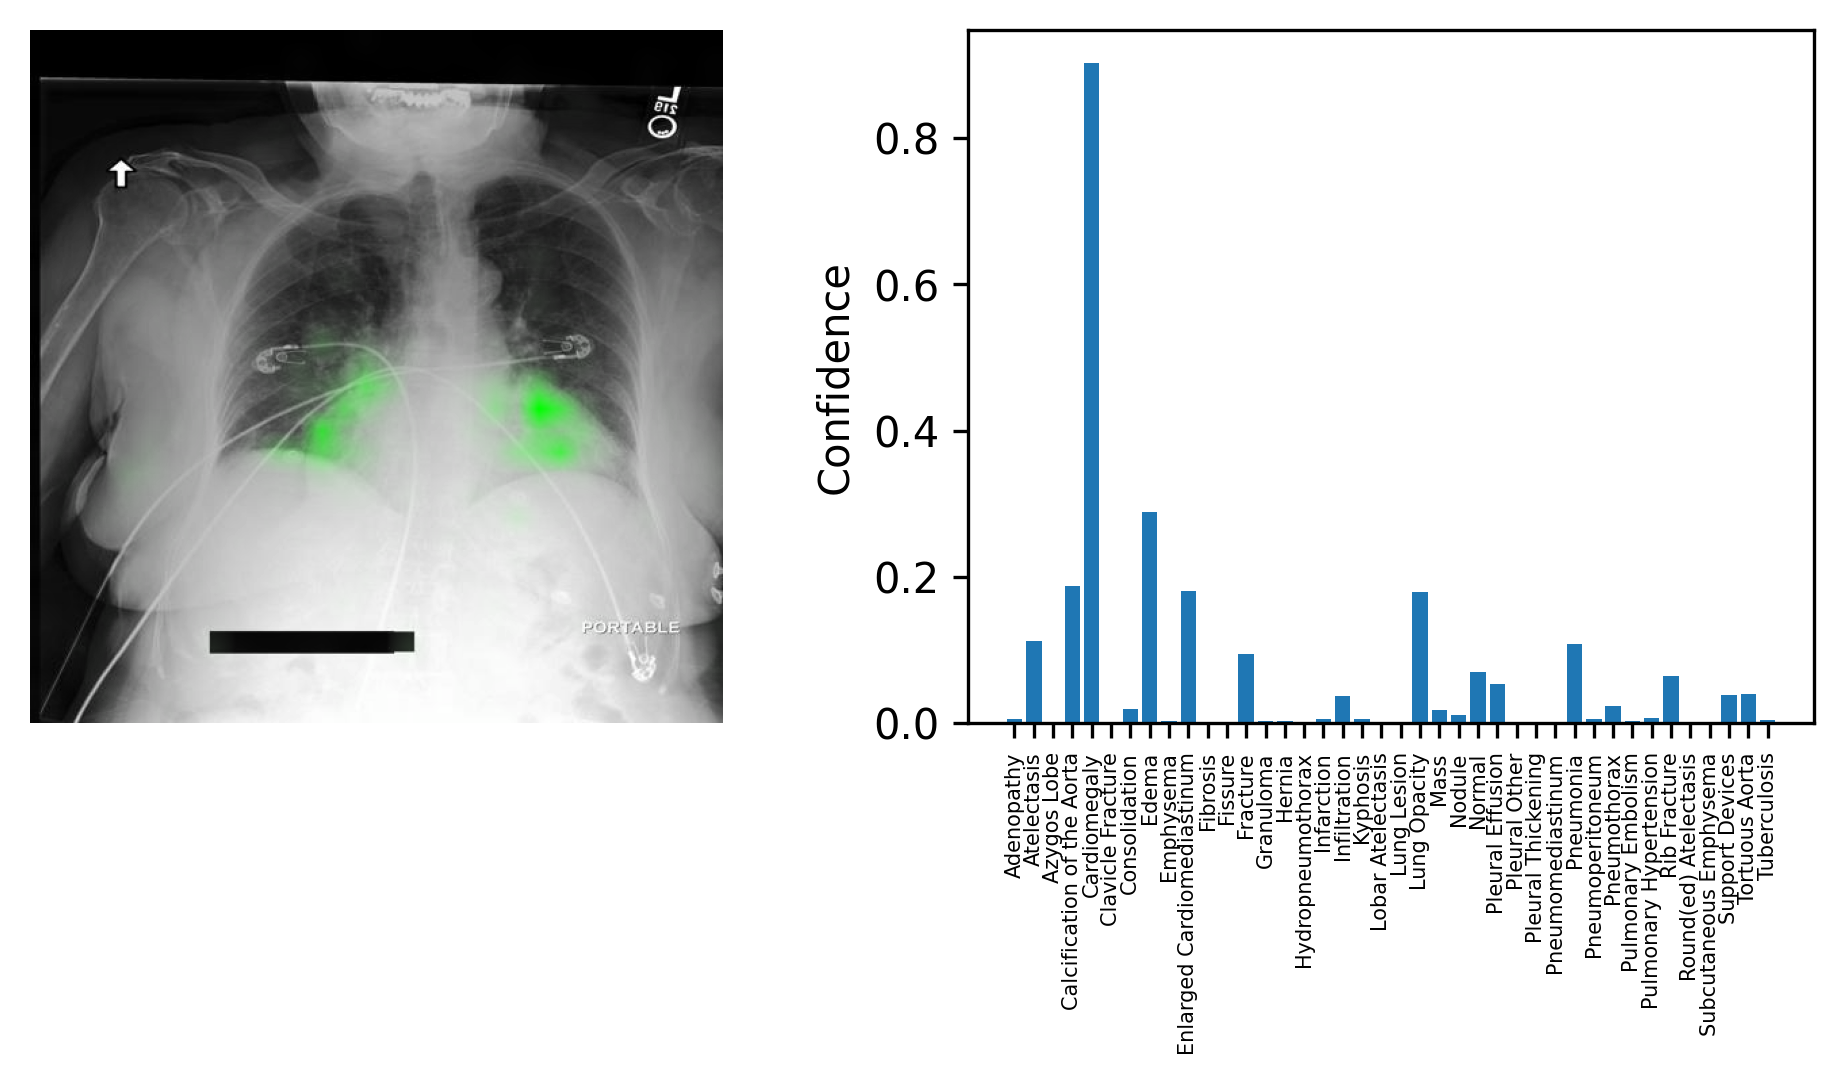

In [8]:
# Define class names
class_name = ['Adenopathy', 'Atelectasis', 'Azygos Lobe', 'Calcification of the Aorta', 'Cardiomegaly', 'Clavicle Fracture', 'Consolidation', 'Edema', 'Emphysema', 'Enlarged Cardiomediastinum', 'Fibrosis', 'Fissure', 'Fracture', 'Granuloma', 'Hernia', 'Hydropneumothorax', 'Infarction', 'Infiltration', 'Kyphosis', 'Lobar Atelectasis', 'Lung Lesion', 'Lung Opacity', 'Mass', 'Nodule', 'Normal', 'Pleural Effusion', 'Pleural Other', 'Pleural Thickening', 'Pneumomediastinum', 'Pneumonia', 'Pneumoperitoneum', 'Pneumothorax', 'Pulmonary Embolism', 'Pulmonary Hypertension', 'Rib Fracture', 'Round(ed) Atelectasis', 'Subcutaneous Emphysema', 'Support Devices', 'Tortuous Aorta', 'Tuberculosis']

# Define color map
color_array = np.zeros((255, 4))
color_array[:, 0] = np.linspace(1, 0, 255) # Red channel
color_array[:, 1] = np.linspace(1, 1, 255) # Red channel
color_array[:, 2] = np.linspace(1, 0, 255) # Blue channel
color_array[:, 3] = 1.0  # Alpha channel (fully opaque)
color_array[:, 3] = np.linspace(0, 1, 255)  # Alpha channel (fully opaque)
custom_cmap = ListedColormap(color_array)

# Show attention maps and confidence
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

ax[0].imshow(Image.open(img_path), cmap='gray')
ax[0].imshow(attentions_avg, cmap=custom_cmap)
ax[0].axis('off')  # Hide the axes

y = probs.cpu().numpy().reshape(-1)
ax[1].bar(range(len(y)), y)
ax[1].set_ylabel('Confidence')
ax[1].set_xticks(range(len(y)))
ax[1].set_xticklabels(class_name, fontsize=5, rotation=90)
plt.show()